# Phase III: First ML Proof of Concept (5\%)

### Team Members:
- Deepanshu Bhagria 
- Ishaan Tayal
- Ignacio Torner Toledo
- Dev Patel

Due to the large amount of data in all our cleaned csv files, we had to randomly pick two csv files from two seasons this year, summer and winter, for two random months (January, July) to identify any patterns. This way, the graphing and analyzing will go more smoothly. Below you can see the new code for cleaning only required csv files:

In [29]:
# importing libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [46]:
def clean_stock_data(df):
    """
    Cleans stock data from yfinance:
    - Flattens MultiIndex columns
    - Resets index to make 'Date' a column
    - Drops missing values
    - Adds daily percent change and moving averages (5-day and 20-day)
    """
    # makes a copy of df
    df = df.copy()
    
    # Flatten MultiIndex columns
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] if col[1] else col[0] for col in df.columns]
    
    # Reset index so Date is a column
    df.reset_index(inplace=True)
    
    # Drop any rows with missing values
    df.dropna(subset=['Close', 'Volume'], inplace=True)
    
    # Convert Date to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Derived features
    df['Daily_Change'] = df['Close'].pct_change() * 100
    df['MA_5'] = df['Close'].rolling(5).mean()
    df['MA_20'] = df['Close'].rolling(20).mean()
    
    # Drop rows with NaN from rolling calculations
    df.dropna(inplace=True)
    
    return df

In [31]:
#Testing the pre-processes data
df = yf.download('AAPL', start='2015-01-01', end='2025-10-25')
df.head()

/var/folders/v4/rl51r6ks60z5gjpkw48kqr7h0000gn/T/ipykernel_49318/3804558087.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2015-01-01', end='2025-10-25')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2015-01-02,24.237551,24.705320,23.798600,24.694235,212818400
2015-01-05,23.554747,24.086807,23.368526,24.006998,257142000
2015-01-06,23.556959,23.816338,23.195601,23.619033,263188400
2015-01-07,23.887278,23.987038,23.654501,23.765347,160423600
2015-01-08,24.805084,24.862725,24.097887,24.215385,237458000


In [32]:
print(df.columns)

MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


In [21]:
# Test
# Printing first 5 rows of cleaned data
df_cleaned = clean_stock_data(df)
df_cleaned.head(1)

,Date,Close,High,Low,Open,Volume,Daily_Change,MA_5,MA_20
19,2015-01-30,25.973391,26.602994,25.904665,26.248288,334982000,-1.463424,25.43291,24.5283


## Part 1
(3%) The implementation (using NumPy) of your first ML model as a function call to the cleaned data

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import probplot, shapiro


## Attempt 1 - Linear Regression Model

adding bias column

In [48]:
#prof code
def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew

prepare_Xy

In [49]:
def prepare_xy(df):
    X = df[['High', 'Low', 'Open', 'Volume', 'Daily_Change', 'MA_5', 'MA_20']].values
    y = df['Close'].values
    return X, y

linear_reg_model

In [50]:
def linear_regression_model(X, y):
    """
    Fits linear regression using the normal equation.
    Returns coefficient vector m.
    """
    X = add_bias_column(X)
    m = np.matmul(np.linalg.inv(np.matmul(X.T , X)), np.matmul(X.T, y))
    return m

 linear_regression_prediction

In [51]:
def linreg_predict(Xnew, ynew, m):
    """
    Computes predictions and evaluation metrics for a linear regression model.

    Args:
        Xnew (array): 1D or 2D array of predictor values (excluding bias column).
        ynew (array): 1D array of observed response values.
        m (array): 1D array of coefficients (including intercept) from line_of_best_fit.

    Returns:
        dict: Contains
            - 'ypreds': Predicted values
            - 'resids': Residuals (ynew - ypreds)
            - 'mse': Mean squared error
            - 'r2': Coefficient of determination (R²)
    """

    Xnew = add_bias_column(Xnew)
    ypreds = np.dot(Xnew, m)
    resids = np.round(ynew - ypreds, 10)
    mse = round((resids**2).mean(), 1)
    r2 = r2_score(ynew, ypreds)


    return {'ypreds': ypreds,
            'resids': resids,
            'mse': mse,
            'r2': r2}


eval-plots

In [ ]:
def evaluate_model(X, y, title):
    """Fit model, predict, print metrics, and generate diagnostic plots."""

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, shuffle=False
    )

    # Train
    m = linear_regression_model(X_train, y_train)

    # Predict
    results = linreg_predict(X_test, y_test, m)
    y_pred = results["ypreds"]
    resids = results["resids"]

    # Print metrics
    print(f"{title} - MSE: {results['mse']:.3f}")
    print(f"{title} - R²: {results['r2']:.4f}")

    # Diagnostic Plots
    plt.figure(figsize=(16, 12))

    # 1. Residuals vs Fitted
    plt.subplot(2, 2, 1)
    plt.scatter(y_pred, resids, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.title("Residuals vs Fitted")
    plt.xlabel("Fitted Values")
    plt.ylabel("Residuals")

    # 2. Residuals vs Order (Independence)
    plt.subplot(2, 2, 2)
    plt.scatter(range(len(resids)), resids, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.title("Residuals vs Order")
    plt.xlabel("Index")
    plt.ylabel("Residuals")

    # 3. Normal Q-Q Plot (Normality)
    plt.subplot(2, 2, 3)
    probplot(resids, dist="norm", plot=plt)
    plt.title("Normal Q-Q Plot")

    # 4. Histogram (Normality)
    plt.subplot(2, 2, 4)
    plt.hist(resids, bins=30, alpha=0.7, edgecolor="black")
    plt.title("Histogram of Residuals")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

    return results


/var/folders/v4/rl51r6ks60z5gjpkw48kqr7h0000gn/T/ipykernel_49318/3068160486.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2015-01-01', end='2025-10-25')
[*********************100%***********************]  1 of 1 completed

Loading and preparing stock data...

Evaluating Stock Price Model

AAPL Closing Price Model - MSE: 1.000
AAPL Closing Price Model - R²: 0.9991



/var/folders/v4/rl51r6ks60z5gjpkw48kqr7h0000gn/T/ipykernel_49318/1783013177.py:7: RuntimeWarning: divide by zero encountered in matmul
  m = np.matmul(np.linalg.inv(np.matmul(X.T , X)), np.matmul(X.T, y))
/var/folders/v4/rl51r6ks60z5gjpkw48kqr7h0000gn/T/ipykernel_49318/1783013177.py:7: RuntimeWarning: overflow encountered in matmul
  m = np.matmul(np.linalg.inv(np.matmul(X.T , X)), np.matmul(X.T, y))
/var/folders/v4/rl51r6ks60z5gjpkw48kqr7h0000gn/T/ipykernel_49318/1783013177.py:7: RuntimeWarning: invalid value encountered in matmul
  m = np.matmul(np.linalg.inv(np.matmul(X.T , X)), np.matmul(X.T, y))


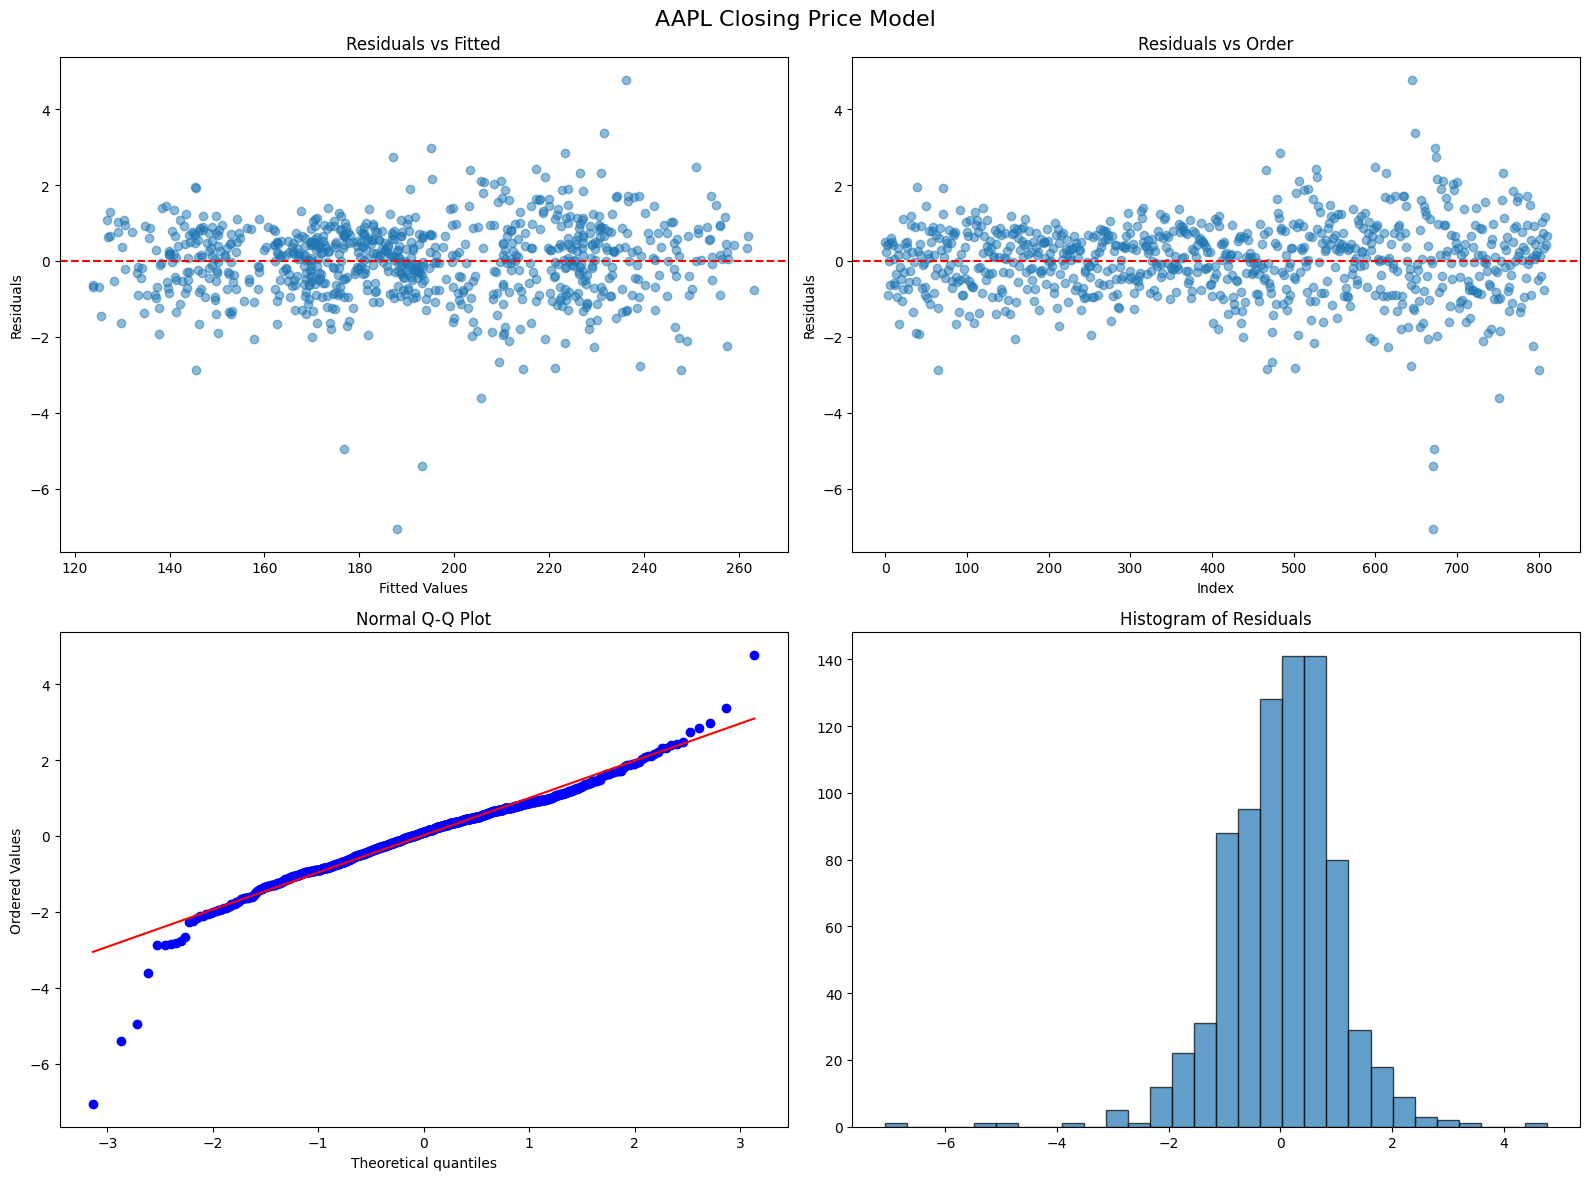

In [ ]:
def main():
    """Load data, clean it, prepare X/y, and evaluate the model."""
    
    print("Loading and preparing stock data...\n")
    
    # Load raw stock data
    df = yf.download('AAPL', start='2015-01-01', end='2025-10-25')
    
    # Clean stock data (your function)
    df_cleaned = clean_stock_data(df)
    
    # Prepare features
    X, y = prepare_xy(df_cleaned)
    
    # Run evaluation
    print("Evaluating Stock Price Model\n")
    evaluate_model(X, y, "AAPL Closing Price Model")
# Run
if __name__ == "__main__":
    main()

### Attempt 2 - Polynomial regression
#### Creating the Design Matrix

Using the `PolynomialFeatures` and `.fit_transform` functions to convert the `hour` ($x$) feature into an array (`X_hour_poly`) that includes columns corresponding to building a quartic model for `tripduration` ($y$) along the lines of: $y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 + \beta_4 x^4$.

In [10]:
# preprocess the dataframe first
df = preprocess_data(df)
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,tripduration,hour
0,5FA2A0E02EC53028,classic_bike,2024-07-11 02:07:46.443,2024-07-11 02:20:34.180,Maverick St at Massport Path,A32044,Maverick St at Massport Path,A32044,42.367741,-71.033360,42.367741,-71.033360,member,12.795617,2
1,5D49B9B78C826FD5,classic_bike,2024-07-19 14:07:03.620,2024-07-19 14:08:06.530,NCAAA - Walnut Ave at Crawford St,B32027,NCAAA - Walnut Ave at Crawford St,B32027,42.316902,-71.091946,42.316902,-71.091946,member,1.048500,14
2,5FEF6FE539C078FB,electric_bike,2024-07-02 09:06:08.296,2024-07-02 09:12:52.886,Medford Sq - Riverside Ave at River St,F32002,Tufts Sq - Main St at Medford St,F32003,42.417680,-71.108055,42.401697,-71.106128,member,6.743167,9
3,709B58276144026B,classic_bike,2024-07-30 13:55:16.971,2024-07-30 14:54:55.077,NCAAA - Walnut Ave at Crawford St,B32027,Harvard Square at Mass Ave/ Dunster,M32018,42.316902,-71.091946,42.373268,-71.118579,casual,59.635100,13
4,15755F52835908F5,classic_bike,2024-07-18 19:24:45.546,2024-07-18 19:42:54.574,Maverick St at Massport Path,A32044,Addison St at Saratoga St,A32054,42.367741,-71.033360,42.385181,-71.015137,casual,18.150467,19


In [11]:
from sklearn.preprocessing import PolynomialFeatures
# prepare the data
X_hour = np.array(df['hour']).reshape(-1,1)
y = df['tripduration']

In [12]:
# degree 4 for the quadratic equation
poly = PolynomialFeatures(degree=4)
# gets the X_poly with bias column in the beginning
X_poly_bias = poly.fit_transform(X_hour)
# removes the bias column
X_poly = X_poly_bias[:, 1:]
print(X_poly[0])

[ 2.  4.  8. 16.]


#### Cross Validation

Using single-fold cross validation with a 70-30 split, we create `Xtrain`, `Xtest`, `ytrain`, and `ytest` (from `X_poly` from Part 1.1 and `y` as defined before).

We fit the model using our own `line_of_best_fit` function to `Xtrain` and `ytrain`, using Numpy.

Then we pass `Xtest`, `ytest`, and the output from the `line_of_best_fit` to our `linreg_predict` function. 

Finally, we print out the cross-validated $MSE$ and $R^2$ values.

In [13]:
def add_bias_column(X):
    """ adds a bias columm
    Args:
        X (array): can be either 1-d or 2-d
    
    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """
    
    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])
    
    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])
        
    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew

In [14]:
def line_of_best_fit(X, y):
    """ returns a vector containing the coefficients for the line of best fit, including an intercept term
    Args:
        X (array): either 1-d or 2-d which includes all the predictor values, not including bias term
        y (array): a 1-d array which includes all corresponding response values to X
        
    Returns:
        m (array): the vector containing the coefficients for the line of best fit, including an intercept term
    """
    # adds a bias column to X
    X_new = add_bias_column(X)
    # calculates the line of best fit
    XtXinv = np.linalg.inv(np.matmul(X_new.T, X_new))
    m = np.matmul(XtXinv, np.matmul(X_new.T, y))
    return m

In [15]:
from sklearn.metrics import r2_score

In [16]:
def linreg_predict(Xnew, ynew, m):
    """ returns a dictionary containing: the predicted values from applying m to Xnew, the residuals, 
    the mean squared error, and the coefficient of determination

    Args:
        Xnew (array): an array, either 1-d or 2-d which includes all the predictor features, not including bias term
        ynew (array): a 1-d array which includes all corresponding response values to Xnew
        m (array): a 1-d array of length which contains the coefficients from the line_of_best_fit function

    Returns:
        output_dict (dictionary): a dictionary that has:
            - 'ypreds' (the predicted values from applying m to Xnew)
            - 'resids' (the residuals, the differences between ynew and ypreds)
            - 'mse' (the mean squared error)
            - 'r2' (the coefficient of determination representing the proportion of variability in ynew explained by the line of best fit
    """
    # initializes an output dictionary for required values
    output_dict = {}
    # adds a bias column to the Xnew array
    Xnew_bias_added = add_bias_column(Xnew)
    # calculates the line of best fit for Xnew with bias and ynew
    # gets the predicted values from applying m to Xnew
    ypreds = np.matmul(Xnew_bias_added, m)
    # gets the residuals
    res = ynew - ypreds
    # gets the mean squared error
    mse = (res**2).mean()
    # gets the R^2
    r2 = r2_score(ynew, ypreds)
    # adds values to the dictionary
    output_dict['ypreds'] = ypreds
    output_dict['resids'] = res
    output_dict['mse'] = mse
    output_dict['r2'] = r2
    return output_dict

In [17]:
# single-fold cross validation
crossval = train_test_split(X_poly, y, test_size=0.3, random_state=3)
Xtrain, Xtest, ytrain, ytest = crossval

# finds the line of best fit
m = line_of_best_fit(Xtrain, ytrain)
model = linreg_predict(Xtest, ytest, m)

# prints out MSE and R^2 values
print('MSE for the first poly regression model = ', model['mse'].round(3))
print('R^2 for the first poly regression model = ', round(model['r2'], 4))

MSE for the first poly regression model =  627.869
R^2 for the first poly regression model =  0.0035


### Attempt 3 - Polynomial Regression with added interaction terms and dummy variables
#### Creating Fitting Model

$$
y = b_0 + b_1 x_1 + b_2 x_1^2 + b_3 x_1^3 + b_4 x_1^4 + b_5x_1x_3 + b_6x_2x_4 + b_7x_1x_4 + b_8x_2x_3
$$

Where:

- $y$: trip duration
- $x_1$: time of day
- $x_2$: member or casual (1 or 0)
- $x_3$: electric or classic bike (1 or 0)

- Polynomial terms $b_0 + b_1 x_1 + b_2 x_1^2 + b_3 x_1^3 + b_4 x_1^4$
- Interaction terms with dummy variables $b_5x_1x_3 + b_6x_2x_4 + b_7x_1x_4 + b_8x_2x_3$

In [18]:
# Prepares the data
X_hour = np.array(df['hour']).reshape(-1,1)
y = df['tripduration']
X_ride_type = df['member_casual'].astype('category').cat.codes.values.reshape(-1, 1)
X_member_type = df['rideable_type'].astype('category').cat.codes.values.reshape(-1, 1)

# degree 4 for the quadratic equation
poly = PolynomialFeatures(degree=4)
# gets the X_poly with bias column in the beginning
X_hour_poly_bias = poly.fit_transform(X_hour)
# removes the bias column
X_hour_poly = X_poly_bias[:, 1:]

# Combines X_hour_poly with interaction terms and dummy variables
X_poly = np.concatenate([
    X_hour_poly,
    X_ride_type * X_member_type,
    X_ride_type * (1 - X_member_type), 
    (1 - X_ride_type) * X_member_type], axis=1)

print(X_poly[0])

[ 2.  4.  8. 16.  0.  1.  0.]


In [19]:
# single-fold cross validation
crossval = train_test_split(X_poly, y, test_size=0.3, random_state=3)
Xtrain, Xtest, ytrain, ytest = crossval

# finds the line of best fit
m = line_of_best_fit(Xtrain, ytrain)
model = linreg_predict(Xtest, ytest, m)

# prints out MSE and R^2 values
print('MSE for the second poly regression model =', model['mse'].round(3))
print('R^2 for the second poly regression model =', round(model['r2'], 4))

MSE for the second poly regression model = 599.699
R^2 for the second poly regression model = 0.0482


## Part 2
(2%) A discussion of the preliminary results:
   - This may include checking of assumptions, generated plots/tables, measures of fit, or other attributes of the analysis
   - It does not have to be fully correct, but as a proof of concept must demonstrate that the group is close to completing the analysis

## Initial Approach
The initial question we proposed for Machine Learning part is "Can we predict the trip duration based on factors such as the time of day, user demographics, and starting/ending stations?", and after further discussions and analysis, we identified we can try building the models based on a Linear Regression for 3 features separately and a Polynomial Regression for one of the features. However, as we moved forward in with the Linear Regression analysis, we got unexpectedly large values for both $MSE$ and $R^2$ for all 3 features. This made us reconsider our initial attempt and go with Polynomial Regression for one of the features (Time of Day). After constructing the model equation and using cross-validation, we received values of $MSE$ = 627.869 and $R^2$ = 0.0035, which showed worse results, compared to Linear Regression. Therefore, we decided to fix our model by incorporating interactions with dummy variables (member_casual and rideable_type), which had values of 1 and 0. Building the polynomial regression model with interactions and dummy variables has slighly improved the $MSE$ = 599.699 and $R^2$ = 0.0482. However, the values were still significantly worse, than the Linear Regression model's ones. Therefore, we we will use the Linear Regression model to discuss the preliminary results.

## Model 1
First, we analyzed Model 1: Time of Day of Linear Regression model. We calculated $MSE$ = 514.094 and $R^2$ = 0.0477, where MSE value is lower than for the polynomial regression models and $R^2$ value is slightly lower than the second polynomial regression model. Based on the first plot of Residuals vs Fitted, we can see that the assumption of Linearity and Constant Variance is violated as the residuals do not follow a linear trend about 0 and also contain multiple outliers. The second plot of Residuals vs Order shows that there is some density of the data points near the y = 0 with mutliple outliers as well, indicating there might be a violation of Independence assumption as well. Looking at the Histogram of Residuals and Q-q plot, we can witness there is strong right-skewedness, showing that there is no normal distribution, meaning violation of Normality assumption. 

## Model 2
Second, we analyzed Model 2: User Demographics of Linear Regression Model. Calculating $MSE$ = 508.001 and $R^2$ = 0.059 shows that this is the highest values we were able to identify. There is a violation of Linearity and Constant Variance assumptions based on the Residuals vs Fitted graph, data points are not equally distributed around y=0 line, they have significant gaps between vertical line patterns of the data points. Moreover, the Independence assumption might be violated due to the density above y = 0 line. Finally, we see that the residuals are right skewed on Q-Q plot and Histogram of residuals. Therefore, the plots also violate the assumptions, despite better looking values.

## Model 3
Finally, the last Model 3: Starting and Ending Stations has $MSE$ = 514.076 and $R^2$ = 0.0478, the values are somewhat similar to the ones from Model 1. The model also fails to meet the assumptions of Linearity and Constant Variance assumptions based on the Residuals vs Fitted graph, data points are not distributed closer to y=0 line, have occasional gaps and outliers. Moreover, the Independence assumption might be violated due to the density above y = 0 line. Finally, we see that the residuals are right skewed on Q-Q plot and Histogram of residuals. 

## Conclusions
These findings paint a complex picture of the bike-sharing prediction challenge. While Linear Regression provided our best results among the attempted approaches, the consistent violations of key assumptions across all models reveal fundamental challenges in our modeling strategy. 

First, the pervasive violations of regression assumptions across all models suggest systemic issues in how we're approaching the prediction task. The violation of linearity assumptions, evidenced by clear patterns in our residual plots, indicates that the relationship between our predictors and trip duration isn't as straightforward as our models assume. For instance, the impact of time of day on trip duration might follow a more complex pattern influenced by rush hours, weekends, or seasonal effects that our linear approach can't capture. Similarly, the relationship between station locations and trip duration might be influenced by geographic features, traffic patterns, or neighborhood characteristics that require more sophisticated modeling approaches.

The heteroscedasticity observed in our models (non-constant variance in residuals) suggests that our predictions' accuracy varies significantly across different conditions. This could indicate that trip durations are more predictable in some circumstances than others – perhaps more consistent during regular commuting hours but more variable during leisure times. This varying predictability challenges our model's ability to provide reliable estimates across all scenarios.

The notably low R² values (ranging from 0.0477 to 0.059) are particularly telling. These values indicate that our models explain less than 6% of the variance in trip durations, leaving over 94% of the variation unexplained. This substantial unexplained variance could stem from several sources, such as missing key features, complex interaction, or hidden variables.

Future research directions might include:
- Exploring more sophisticated modeling techniques such as mixed-effects models to account for hierarchical structure in the data
- Investigating even more additional features that might better explain trip duration variability
- Considering non-parametric approaches that don't rely on the strict assumptions of linear regression
- Implementing geospatial modeling techniques to better capture the impact of station locations

 Understanding these limitations and potential improvements is crucial for developing more effective prediction models in future iterations. The complexity revealed by our analysis suggests that successful trip duration prediction might require a more nuanced, multi-model approach that can adapt to different conditions and user patterns. Our results demonstrate the challenges of real-world predictive modeling and the importance of thorough diagnostic testing, even when working with seemingly straightforward prediction tasks.